# install moabb & braindecode

In [ ]:
pip install moabb

     |████████████████████████████████| 112kB 7.8MB/s 
     |████████████████████████████████| 27.4MB 155kB/s 
     |████████████████████████████████| 143kB 55.2MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 645kB 36.8MB/s 
     |████████████████████████████████| 6.8MB 34.3MB/s 
     |████████████████████████████████| 7.0MB 24.2MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install braindecode

     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 133kB 30.8MB/s 


In [ ]:
pip install -U https://api.github.com/repos/shivar2/braindecode/zipball/master

     \ 307kB 7.7MB/s
  Created wheel for Braindecode: filename=Braindecode-0.5-cp37-none-any.whl size=67275 sha256=9e5f6feae2e8baaf46234aec24d88def4733032371f425304967651d6d1964e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9hpegl8/wheels/e8/96/7e/9b71798fc04d312683ade7e3a639b36579b720176c6a54dc86
Successfully built Braindecode
  Found existing installation: Braindecode 0.5.1
    Uninstalling Braindecode-0.5.1:
      Successfully uninstalled Braindecode-0.5.1


# connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
os.chdir('/content/drive/MyDrive/MotorImagery-Classification')

# subject

In [ ]:
subject_id_list = [1]

# load data

In [ ]:
import torch

dataset = torch.load('data-file/BNCI2014001/' + str(subject_id) + '.pt')

 (array([[ 0.00797094],
         [ 0.0070896 ],
         [ 0.00591111],
         [ 0.00382163],
         [ 0.00190235],
         [ 0.00237717],
         [ 0.00272541],
         [-0.00048842],
         [-0.00114953],
         [-0.00197128],
         [-0.00155227],
         [-0.00042618],
         [ 0.00668896],
         [-0.00800312],
         [-0.00724566],
         [-0.00507621],
         [-0.00277314],
         [ 0.00079904],
         [-0.00397389],
         [-0.00264974],
         [ 0.00016922],
         [ 0.0019671 ]]), None),
 (array([[-0.29198963],
         [-0.64923242],
         [-0.50549775],
         [-0.31653866],
         [-0.09033728],
         [-0.09527948],
         [-0.54562111],
         [-0.63960507],
         [-0.48594792],
         [-0.32398644],
         [-0.05221979],
         [ 0.043337  ],
         [-0.3129747 ],
         [-0.32999248],
         [-0.17392593],
         [-0.1302717 ],
         [ 0.0717304 ],
         [ 0.11414022],
         [-0.0696513 ],
       

# *input window samples* 

In [ ]:
input_window_samples = 1000

# Create model

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans and time steps from dataset
n_chans = dataset[0][0].shape[0]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
)

# Send model to GPU
if cuda:
    model.cuda()


And now we transform model with strides to a model that outputs dense prediction, so we can use it to obtain predictions for all crops.

In [ ]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape
to_dense_prediction_model(model)

# To know the models’ receptive field, we calculate the shape of model output for a dummy input.

n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]


# Cut Compute Windows

for cropped trials


In [ ]:
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True
)

## Split dataset into train and valid

In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

# Training

train model for cropped trials

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 64
n_epochs = 50

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)



# Plot Results

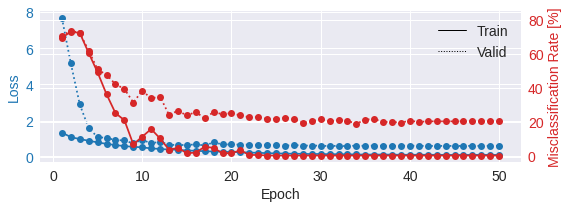

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()